In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import precision_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


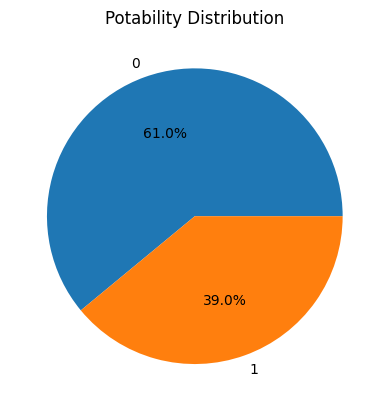

In [5]:
counts = df["Potability"].value_counts()

plt.pie(counts, labels=counts.index, autopct="%1.1f%%")
plt.title("Potability Distribution")
plt.show()

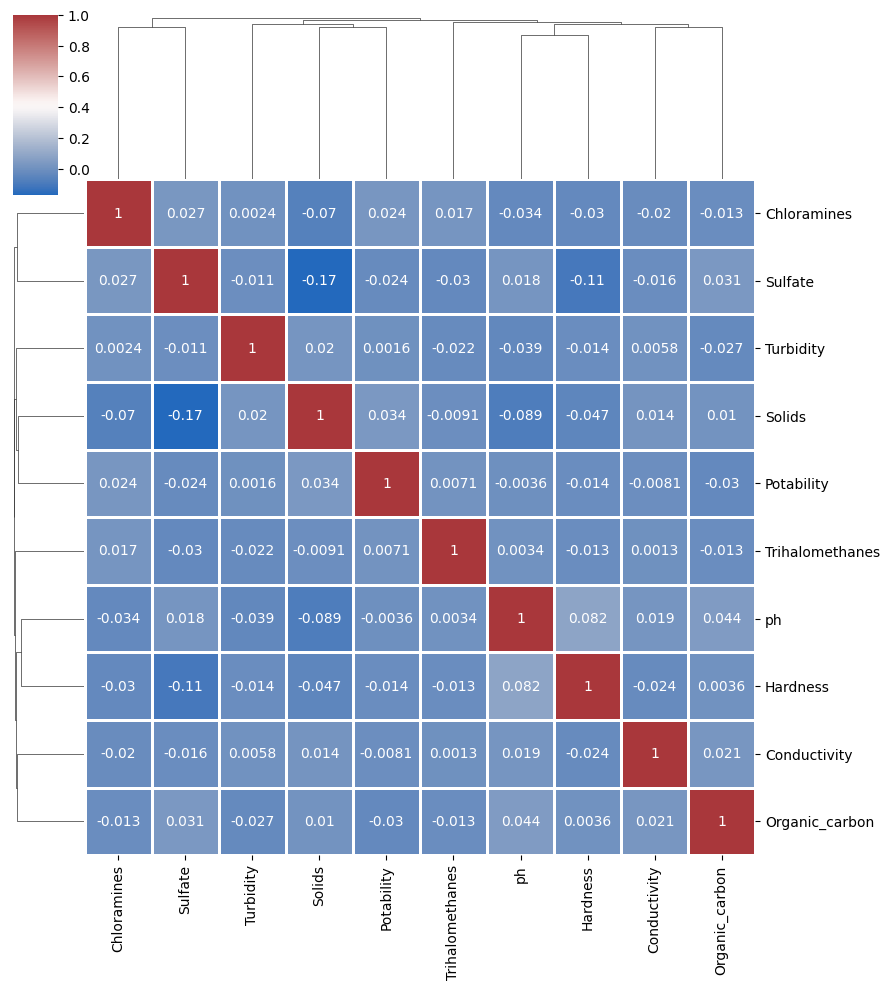

In [6]:
df.corr()
sns.clustermap(df.corr(), cmap = "vlag", dendrogram_ratio=(0.1, 0.2), annot = True, linewidths = .8, figsize=(9,10))
plt.show()

In [7]:
non_potable = df["Potability"] == 0
non_potable

0        True
1        True
2        True
3        True
4        True
        ...  
3271    False
3272    False
3273    False
3274    False
3275    False
Name: Potability, Length: 3276, dtype: bool

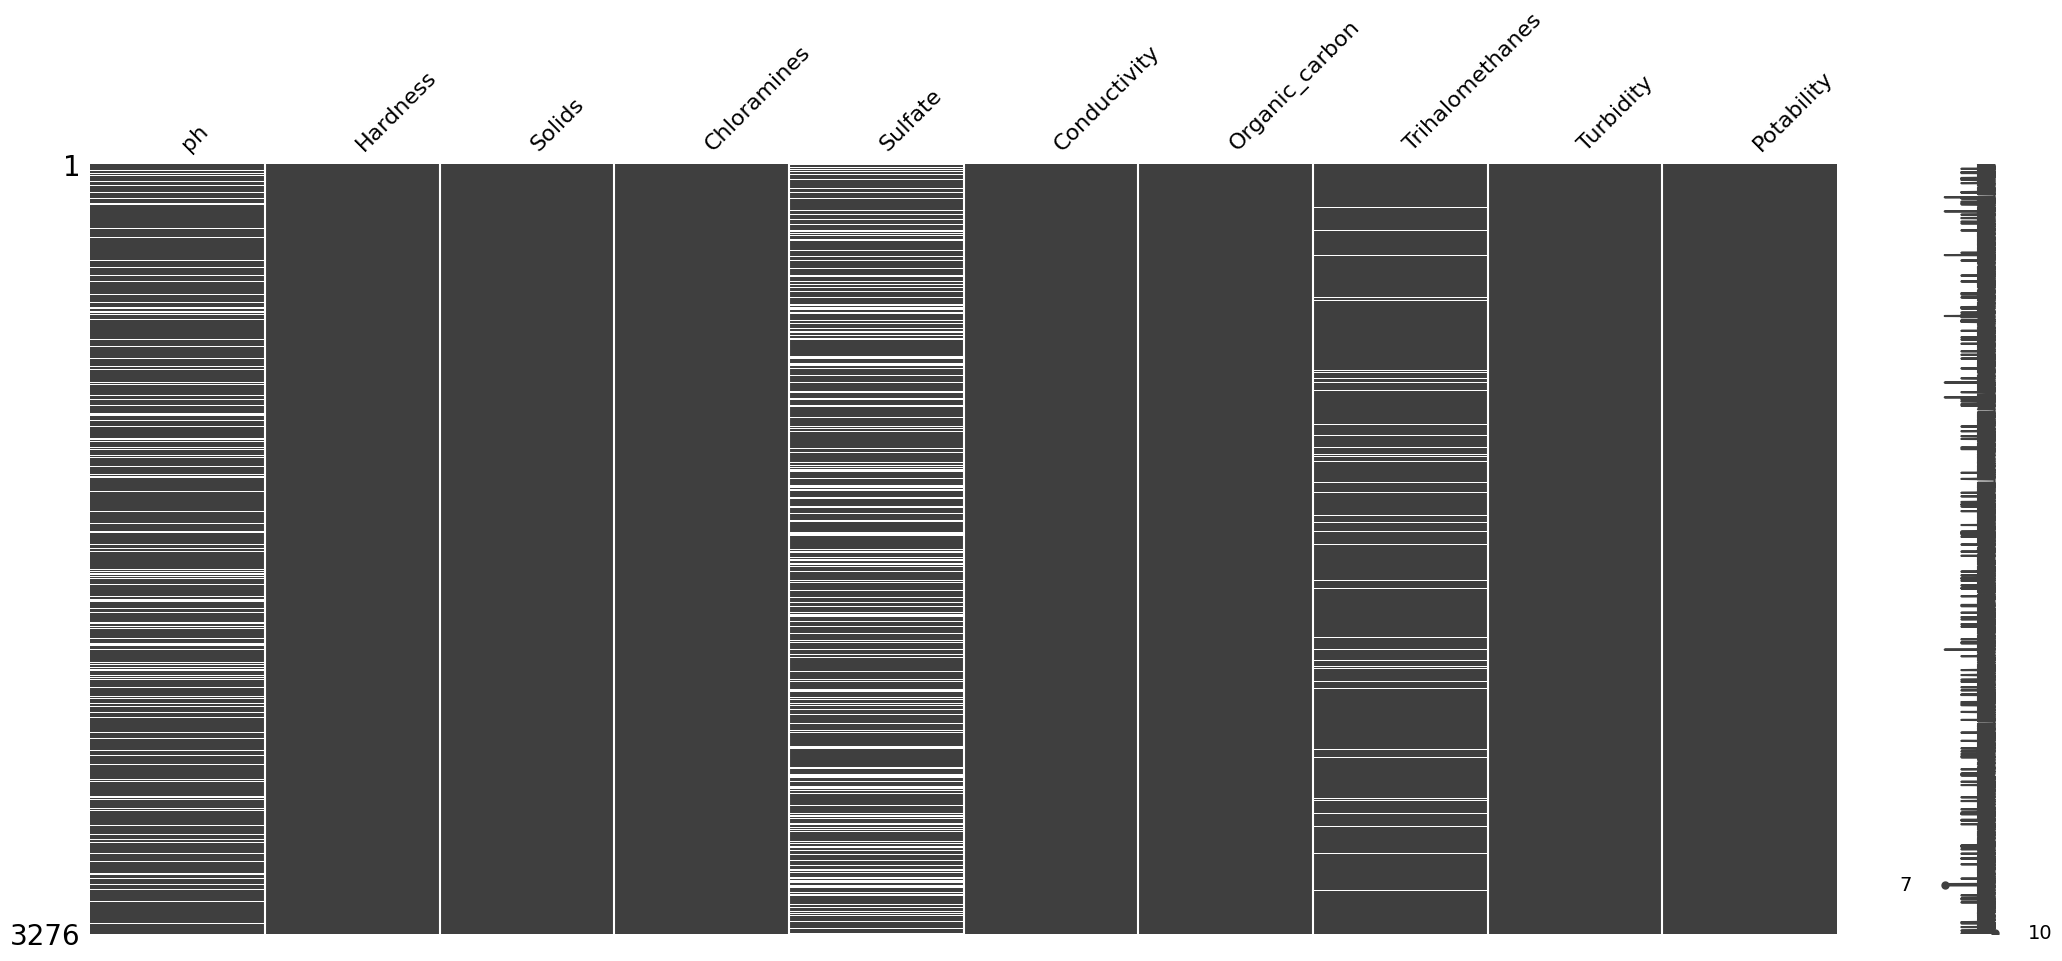

In [9]:
msno.matrix(df)
plt.show()

In [11]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [12]:
df["ph"].fillna(value=df["ph"].mean(), inplace=True)
df["Sulfate"].fillna(value=df["Sulfate"].mean(), inplace=True)
df["Trihalomethanes"].fillna(value=df["Trihalomethanes"].mean(), inplace=True)

In [13]:
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [14]:
X = df.drop("Potability", axis=1).values
y = df["Potability"].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2293, 9)
(983, 9)
(2293,)
(983,)


In [16]:
x_train_max = np.max(X_train)
x_train_min = np.min(X_train)

X_train = (X_train - x_train_min)/(x_train_max-x_train_min)
X_test = (X_test - x_train_min)/(x_train_max-x_train_min)

In [17]:
models = [("DTC", DecisionTreeClassifier(max_depth=3)),
          ("RF", RandomForestClassifier())]

In [18]:
final_results = []
cmlist = []
for name, model in models:
    model.fit(X_train, y_train)
    model_result = model.predict(X_test)
    score = precision_score(y_test, model_result)
    cm = confusion_matrix(y_test, model_result)

    final_results.append((name, score))
    cmlist.append((name, cm))
final_results

[('DTC', 0.72), ('RF', 0.6127450980392157)]

In [19]:
model_params = { "Random Forest": {
    "model": RandomForestClassifier(),
    "params": {
        "n_estimators": [10, 50, 100],
        "max_features": ["auto", "sqrt", "log2"],
        "max_depth": list(range(1,21,3))
    }
}}
model_params

{'Random Forest': {'model': RandomForestClassifier(),
  'params': {'n_estimators': [10, 50, 100],
   'max_features': ['auto', 'sqrt', 'log2'],
   'max_depth': [1, 4, 7, 10, 13, 16, 19]}}}

In [22]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
scores = []

for model_name, params in model_params.items():
    rs = RandomizedSearchCV(params["model"], params["params"], cv=cv, n_iter=10)
    rs.fit(X, y)
    scores.append({
        "model": model_name,
        "best_score": rs.best_score_,
        "best_params": rs.best_params_
    })

scores


[{'model': 'Random Forest',
  'best_score': np.float64(0.6735403090672127),
  'best_params': {'n_estimators': 100,
   'max_features': 'sqrt',
   'max_depth': 13}}]